In [9]:
from langgraph.graph import MessagesState, StateGraph

def node1(state: MessagesState):
    input1 = state['messages'][0].content
    response = str(input1) + ", From Node-1: Hello, Human"
    return {"messages": [response]}

def node2(state: MessagesState):
    input2 = state['messages'][-1].content
    response =  str(input2) + " From Node-2, Hello, Human and Node-1"
    return {"messages": [response]}

In [10]:
def routing_logic(state: MessagesState):
    input3 = state['messages'][-1].content
    # If the input is more than 10 size, then we route to the "tool" node
    if len(input3)>80:
        return "tool"
    # Otherwise, we stop (reply to the user)
    return "__end__"

#This tool make the input upper case
def some_tool(state: MessagesState):
    tool_input = state['messages'][-1].content
    print(tool_input)
    response = tool_input.upper()
    return {"messages": [response]}

In [11]:
from langgraph.graph import END, START

workflow = StateGraph(MessagesState)

workflow.add_node("Node-1", node1)
workflow.add_node("Node-2", node2)

# #tool_node = ToolNode(tools)
workflow.add_node("tool", some_tool)

workflow.add_edge(START, "Node-1")
workflow.add_edge("Node-1", "Node-2")

# # We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `Node-2`.
    source="Node-2",
    # Next, we pass in the router function that will determine next Node.
    path = routing_logic,
    # This means these are the edges taken after the `Node-2` node is called.
    path_map={
        "tool": "tool",
        "__end__": "__end__"
    }
)
workflow.add_edge("tool", END)

graph_with_state = workflow.compile()

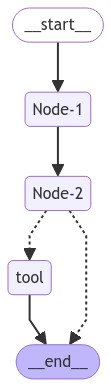

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph_with_state.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [13]:
inputs =  {
             "messages": [
                 {"role": "human", "content": "Hi I am Human, I am from planet Earth"}
             ]
         }

for output in graph_with_state.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"'{key}':")
        print("---")
        print(value)
    print("\n~~~~~~~~\n")

'Node-1':
---
{'messages': ['Hi I am Human, I am from planet Earth, From Node-1: Hello, Human']}

~~~~~~~~

'Node-2':
---
{'messages': ['Hi I am Human, I am from planet Earth, From Node-1: Hello, Human From Node-2, Hello, Human and Node-1']}

~~~~~~~~

Hi I am Human, I am from planet Earth, From Node-1: Hello, Human From Node-2, Hello, Human and Node-1
'tool':
---
{'messages': ['HI I AM HUMAN, I AM FROM PLANET EARTH, FROM NODE-1: HELLO, HUMAN FROM NODE-2, HELLO, HUMAN AND NODE-1']}

~~~~~~~~



In [14]:
from langchain_core.messages import HumanMessage
inputs =  {
             "messages": [HumanMessage(content="Hi")]
         }

for output in graph_with_state.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"'{key}':")
        print("---")
        print(value)
    print("\n~~~~~~~~\n")

'Node-1':
---
{'messages': ['Hi, From Node-1: Hello, Human']}

~~~~~~~~

'Node-2':
---
{'messages': ['Hi, From Node-1: Hello, Human From Node-2, Hello, Human and Node-1']}

~~~~~~~~

